In [79]:
"""
Created on Nov 12 2021

@author: Caroline Hixon


Shortcut Learning in NN using MedMNIST dataset 
    - Shortcut Learning (Geirhos et al, 2020) is found when data performs well with IID data but not OOD data
    - Shortcuts revealed when tested under slightly different circumstances 


Study Methodology
    Models:
        - Simple FC neural net (3 dense layers)
        - Baseline CNN (1 Conv2D, kernel size 3, relu + maxpool size 2)
        - CNN with BN and dropout (2 Conv2D layers, keneral size 3, relu + maxpool size 2, Batch Norm, dropout of 0.5)
        - ResNet (4 residual layers)
    Testing Environment:
        - No augmentation
        - Test set augmentation (random shifts, rotations)
        - Train and test set augmentation (random shifts, rotations)
        
Data
    - Breast ultrasound
    - Binary class (2)
    - 780 samples
    - Access to data: https://zenodo.org/record/6496656#.Ym7bZ-jMKHs

Results
    - Highest train acc: 90.66 from CNN with dropout and test only augmentation
    - Highest validation acc: 80.77 from Baseline CNN and test only augmentation
    - Highest test acc: 79.49 from Baseline CNN and test only augmentation
    
    
""" 


In [ ]:
# import statements

import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt

import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [114]:
# Initialize, load data, split and augment data

num_classes = 2
input_shape = (28, 28, 1)
data_aug = False
both = False

breast_set = 'Desktop/breastmnist.npz'

def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['train_images'], f['train_labels']
        x_val, y_val = f['val_images'], f['val_labels'] 
        x_test, y_test = f['test_images'], f['test_labels']

        return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data(breast_set)

x_train = x_train.astype("float32") / 255
x_val = x_val.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = np.expand_dims(x_train, -1)
x_val = np.expand_dims(x_val, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_test.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

if data_aug:
    datagen = ImageDataGenerator(rotation_range=90)
    datagen.fit(x_test)
    if both:
        datagen.fit(x_train)
        datagen.fit(x_val)

x_train shape: (156, 28, 28, 1)
546 train samples
156 test samples


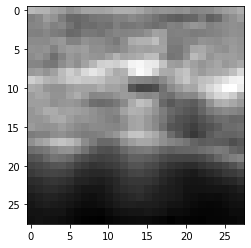

In [119]:
# pick a sample to plot
sample = 3
image = x_train[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

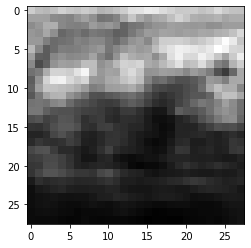

In [120]:
# pick a sample to plot
sample = 13
image = x_train[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

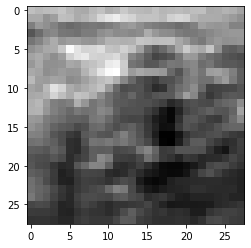

In [121]:
# pick a sample to plot
sample = 23
image = x_train[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

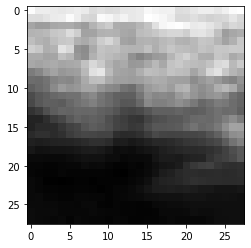

In [122]:
# pick a sample to plot
sample = 33
image = x_train[sample]
# plot the sample
fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_43 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_94 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_95 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
18/18 [==============================] - 1s 28ms/step - loss: 1.0525 - accuracy: 0.6978 - val_loss: 0.7650 - val_accuracy: 0.7308
Epoch 2/15
18/18 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.7308 - val_

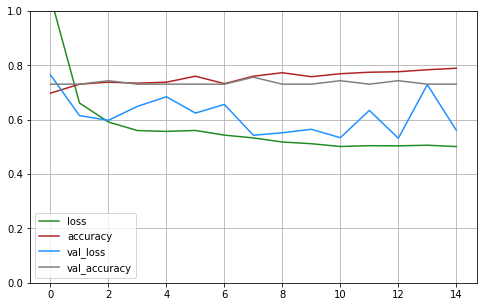

Model - NN - accuracy: [0.6978021860122681, 0.7307692170143127, 0.738095223903656, 0.7344322204589844, 0.738095223903656, 0.7600732445716858, 0.732600748538971, 0.7600732445716858, 0.7728937864303589, 0.7582417726516724, 0.7692307829856873, 0.7747252583503723, 0.7765567898750305, 0.7838827967643738, 0.7893772721290588]
Model - NN - val accuracy: [0.7307692170143127, 0.7307692170143127, 0.7435897588729858, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7564102411270142, 0.7307692170143127, 0.7307692170143127, 0.7435897588729858, 0.7307692170143127, 0.7435897588729858, 0.7307692170143127, 0.7307692170143127]
5/5 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.7436
Model - NN - test loss: 58.71579051017761
Model - NN - test accuracy: 74.35897588729858


In [102]:
# BASIC SEQUENTIAL NN
# Used for comparison to CNN

modelNN = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax') 
])

modelNN.summary()

modelNN.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
historyNN = modelNN.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))

pd.DataFrame(historyNN.history).plot(figsize=(8,5),  color=('forestgreen', 'firebrick', 'dodgerblue', 'grey'))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

print("Model - NN - accuracy:", historyNN.history['accuracy'])
print("Model - NN - val accuracy:", historyNN.history['val_accuracy'])

test_loss, test_acc = modelNN.evaluate(x_test, y_test)
print("Model - NN - test loss:", test_loss * 100)
print("Model - NN - test accuracy:", test_acc * 100)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_167 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 100)               540900    
_________________________________________________________________
dense_97 (Dense)             (None, 2)                 202       
Total params: 541,422
Trainable params: 541,422
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15


C:\Users\Caroline\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 1s 51ms/step - loss: 0.6213 - accuracy: 0.7179 - val_loss: 0.5882 - val_accuracy: 0.7308
Epoch 2/15
6/6 [==============================] - 0s 30ms/step - loss: 0.5803 - accuracy: 0.7308 - val_loss: 0.5863 - val_accuracy: 0.7308
Epoch 3/15
6/6 [==============================] - 0s 32ms/step - loss: 0.5679 - accuracy: 0.7308 - val_loss: 0.5698 - val_accuracy: 0.7308
Epoch 4/15
6/6 [==============================] - 0s 31ms/step - loss: 0.5641 - accuracy: 0.7308 - val_loss: 0.5578 - val_accuracy: 0.7308
Epoch 5/15
6/6 [==============================] - 0s 30ms/step - loss: 0.5468 - accuracy: 0.7308 - val_loss: 0.5533 - val_accuracy: 0.7308
Epoch 6/15
6/6 [==============================] - 0s 30ms/step - loss: 0.5403 - accuracy: 0.7308 - val_loss: 0.5410 - val_accuracy: 0.7308
Epoch 7/15
6/6 [==============================] - 0s 31ms/step - loss: 0.5292 - accuracy: 0.7308 - val_loss: 0.5312 - val_accuracy: 0.7436
Epoch 8/15
6/6 [======================

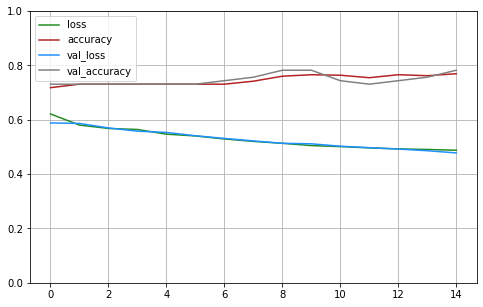

Model - BNN - accuracy: [0.7179487347602844, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7417582273483276, 0.7600732445716858, 0.7655677795410156, 0.7637362480163574, 0.7545787692070007, 0.7655677795410156, 0.761904776096344, 0.7692307829856873]
Model - BNN - val accuracy: [0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7435897588729858, 0.7564102411270142, 0.7820512652397156, 0.7820512652397156, 0.7435897588729858, 0.7307692170143127, 0.7435897588729858, 0.7564102411270142, 0.7820512652397156]
5/5 [==============================] - 0s 4ms/step - loss: 0.4921 - accuracy: 0.7756
Model - BNN - test loss: 49.208030104637146
Model - BNN - test accuracy: 77.56410241127014


In [103]:
# BASELINE CNN

epochs = 15
batch_size = 100

baseline_model = keras.Sequential([
    
        #first layer
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)),
        layers.MaxPooling2D(pool_size=(2, 2)),
    
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ])

baseline_model.summary()

opt = optimizers.SGD(lr=0.01, momentum=0.9)
baseline_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
historyCNN = baseline_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

pd.DataFrame(historyCNN.history).plot(figsize=(8,5),  color=('forestgreen', 'firebrick', 'dodgerblue', 'grey'))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print("Model - BNN - accuracy:", historyCNN.history['accuracy'])
print("Model - BNN - val accuracy:", historyCNN.history['val_accuracy'])
test_loss, test_acc = baseline_model.evaluate(x_test, y_test)
print("Model - BNN - test loss:", test_loss * 100)
print("Model - BNN - test accuracy:", test_acc * 100)


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_167 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 100)               540900    
_________________________________________________________________
dense_97 (Dense)             (None, 2)                 202       
Total params: 541,422
Trainable params: 541,422
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15


C:\Users\Caroline\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 1s 110ms/step - loss: 1.2200 - accuracy: 0.6227 - val_loss: 0.6418 - val_accuracy: 0.7308
Epoch 2/15
6/6 [==============================] - 0s 75ms/step - loss: 0.6039 - accuracy: 0.7216 - val_loss: 0.5988 - val_accuracy: 0.7308
Epoch 3/15
6/6 [==============================] - 0s 75ms/step - loss: 0.5509 - accuracy: 0.7234 - val_loss: 0.5615 - val_accuracy: 0.7308
Epoch 4/15
6/6 [==============================] - 0s 78ms/step - loss: 0.4638 - accuracy: 0.7729 - val_loss: 0.5615 - val_accuracy: 0.7308
Epoch 5/15
6/6 [==============================] - 0s 77ms/step - loss: 0.4732 - accuracy: 0.7784 - val_loss: 0.5666 - val_accuracy: 0.7308
Epoch 6/15
6/6 [==============================] - 0s 80ms/step - loss: 0.4373 - accuracy: 0.7967 - val_loss: 0.5673 - val_accuracy: 0.7308
Epoch 7/15
6/6 [==============================] - 0s 81ms/step - loss: 0.4135 - accuracy: 0.8168 - val_loss: 0.5723 - val_accuracy: 0.7308
Epoch 8/15
6/6 [=====================

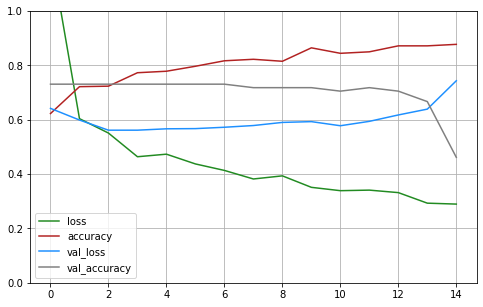

Model - CNN2 - accuracy: [0.622710645198822, 0.721611738204956, 0.7234432101249695, 0.7728937864303589, 0.778388261795044, 0.7967032790184021, 0.8168498277664185, 0.8223443031311035, 0.8150182962417603, 0.8644688725471497, 0.8443223237991333, 0.8498168587684631, 0.8717948794364929, 0.8717948794364929, 0.877289354801178]
Model - CNN2 - val accuracy: [0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7179487347602844, 0.7179487347602844, 0.7179487347602844, 0.7051281929016113, 0.7179487347602844, 0.7051281929016113, 0.6666666865348816, 0.4615384638309479]
5/5 [==============================] - 0s 7ms/step - loss: 0.7396 - accuracy: 0.4808
Model - CNN2 - test loss: 73.9594578742981
Model - CNN2 - test accuracy: 48.076921701431274


In [113]:
# BASELINE CNN

epochs = 15
batch_size = 100

CNN_model = keras.Sequential([
    
        #first layer
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
    
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", input_shape=(28,28,1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
    
    
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

CNN_model.summary()

opt = optimizers.SGD(lr=0.01, momentum=0.9)
CNN_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
historyCNN2 = CNN_model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

pd.DataFrame(historyCNN2.history).plot(figsize=(8,5),  color=('forestgreen', 'firebrick', 'dodgerblue', 'grey'))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print("Model - CNN2 - accuracy:", historyCNN2.history['accuracy'])
print("Model - CNN2 - val accuracy:", historyCNN2.history['val_accuracy'])
test_loss, test_acc = CNN_model.evaluate(x_test, y_test)
print("Model - CNN2 - test loss:", test_loss * 100)
print("Model - CNN2 - test accuracy:", test_acc * 100)



Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_185 (Conv2D)             (None, 14, 14, 64)   3200        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, 14, 14, 64)   256         conv2d_185[0][0]                 
__________________________________________________________________________________________________
activation_134 (Activation)     (None, 14, 14, 64)   0           batch_normalization_154[0][0]    
___________________________________________________________________________________________

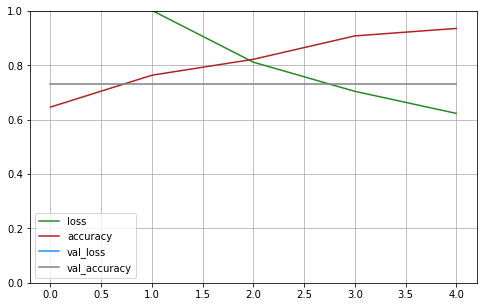

Model - rn - accuracy: [0.6465201377868652, 0.7637362480163574, 0.8223443031311035, 0.9084249138832092, 0.9358974099159241]
Model - rn - val accuracy: [0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127, 0.7307692170143127]
5/5 [==============================] - 0s 44ms/step - loss: 1.6412 - accuracy: 0.7308
Model - rn - test loss: 164.12310600280762
Model - rn - test accuracy: 73.07692170143127


In [107]:
epochs = 5
batch_size = 100
data_augmentation = False
img_size = 28
input_size = (28,28,1)
num_classes = 2
num_filters = 64
num_blocks = 4
num_sub_blocks = 2

inputs = Input(shape=input_size)
x = Conv2D(num_filters, padding='same', kernel_initializer='he_normal', kernel_size=7, strides=2, kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
            
        y = Conv2D(num_filters, kernel_size=3, padding='same', strides=strides, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        
        y = Conv2D(num_filters, kernel_size=3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters, kernel_size=1, padding='same', strides=2, kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
       
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters

x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,activation='softmax', kernel_initializer='he_normal')(y)

modelrn = Model(inputs=inputs, outputs=outputs)
modelrn.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
modelrn.summary()

historyRN = modelrn.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True
              )

pd.DataFrame(historyRN.history).plot(figsize=(8,5),  color=('forestgreen', 'firebrick', 'dodgerblue', 'grey'))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
print("Model - rn - accuracy:", historyRN.history['accuracy'])
print("Model - rn - val accuracy:", historyRN.history['val_accuracy'])

test_loss, test_acc = modelrn.evaluate(x_test, y_test)
print("Model - rn - test loss:", test_loss * 100)
print("Model - rn - test accuracy:", test_acc * 100)